Part 1: Analyse and Explore the Climate Data
In this section, you’ll use Python and SQLAlchemy to do a basic climate analysis and data exploration of your climate database. Specifically, you’ll use SQLAlchemy ORM queries, Pandas, and Matplotlib. To do so, complete the following steps:

Note that you’ll use the provided files (climate_starter.ipynb and hawaii.sqlite) to complete your climate analysis and data exploration.

Use the SQLAlchemy create_engine() function to connect to your SQLite database.

Use the SQLAlchemy automap_base() function to reflect your tables into classes, and then save references to the classes named station and measurement.

Link Python to the database by creating a SQLAlchemy session.

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
from sqlalchemy import inspect
inspector = inspect(engine)


In [10]:
# get table names
inspector.get_table_names()


['measurement', 'station']

In [11]:
# get measurement table columns names and type
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# get station table columns names and type
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# number of  dates recorded
session.query(func.count(Measurement.date)).all()

[(19550,)]

# Exploratory Precipitation Analysis

In [19]:
# Find the older date in the data set.
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
earliest_date


('2010-01-01',)

In [20]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23',)

In [21]:

#  Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
####### Design a Query to Retrieve the Last 12 Months of Precipitation Data and plot the results
prcp_data= session.query(Measurement.date, Measurement.prcp) \
                      .filter(Measurement.date >= dt.datetime.strftime(one_year_ago, "%Y-%m-%d")) \
                     .filter(Measurement.prcp.isnot(None)) \
                      .order_by(Measurement.date).all()




In [23]:
# Perform a Query to Retrieve the Data and Precipitation Scores
all_scores = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()

In [27]:
# Save the Query Results as a Pandas DataFrame and Set the Index to the Date Column & Sort the Dataframe Values by `date`
prcp_df = pd.DataFrame(prcp_data, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True,)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.0
2016-08-23,3.8
2016-08-23,1.3
2016-08-23,0.5
2016-08-23,45.5


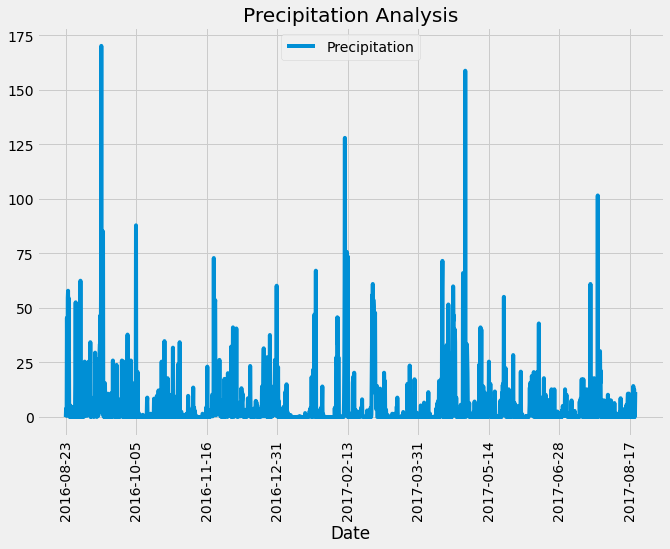

In [29]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation Analysis", figsize=(10,7))
plt.legend(loc='upper center')
plt.xticks(rotation=90)
plt.ylabel="mm"
plt.savefig("Images/precipitation.png")
plt.show()


In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station).group_by(Station.station).count()
stations



9

In [34]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max = session.query(func.max(Measurement.tobs)).all()
min = session.query(func.min(Measurement.tobs)).all()
avg = session.query(func.avg(Measurement.tobs)).all()


print(min, max, avg)


[(11.7,)] [(30.6,)] [(22.8321176470585,)]


In [39]:
# Using the most active station id

most_active = session.query(Measurement.station, Station.name, func.count(Station.id)) \
                  .filter(Measurement.station == Station.station) \
                  .group_by(Station.station, Station.name) \
                  .order_by(func.count(Station.id).desc()).first()
most_active

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

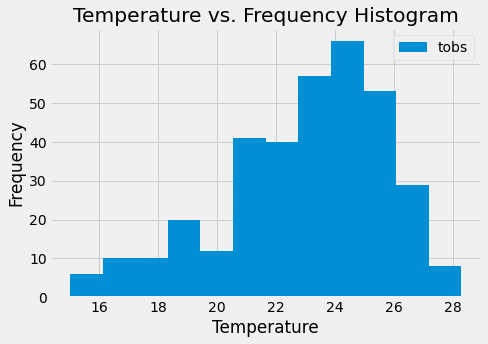

In [40]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

# Save the Query Results as a Pandas DataFrame
tobs_data_df = pd.DataFrame(tobs_data, columns=["tobs"])

# We need 12 bins since the observation is for twelve months

tobs_data_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(7,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Images/StationAnalysis.png")
plt.show()


In [41]:
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()



In [42]:
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(16.7, 20.873214285714287, 23.3)]


In [43]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
startdate = '2017-01-01'
enddate = '2017-01-07'
tempresult = calc_temps(startdate,enddate)[0]
tempresult


(16.7, 20.202439024390255, 23.3)

In [45]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
startdate = '2017-01-01'
enddate = '2017-01-07'

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
queryresult = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
stations = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
stations

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,5.943,15.6
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,2.133,15.3
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,46.449,15.2
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,4.450,8.9
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,10.027,5.1
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.914,0.0


##  Daily Temperature Normals

In [46]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
#from teh starter code and used to test
def daily_normal(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normal("01-01")

[(16.7, 20.64230769230769, 25.0)]

In [47]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normal`

# Set the start and end date of the trip

startdate = '2017-01-01'
enddate = '2017-01-07'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

dtobj = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(enddate, '%Y-%m-%d')

tripdates = []
normal =[]
while (dtobj <= enddtobj):
    tripdates.append(dt.datetime.strftime(dtobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(dtobj,'%m-%d')
    normal.append(list(np.ravel(daily_normal(datestr))))
    dtobj = dtobj + dt.timedelta(days = 1)
normal



[[16.7, 20.64230769230769, 25.0],
 [15.6, 20.781132075471696, 25.0],
 [16.7, 20.50363636363636, 25.0],
 [14.4, 21.112280701754386, 24.4],
 [13.3, 19.976785714285718, 24.4],
 [16.1, 20.53333333333334, 24.4],
 [13.9, 20.301754385964912, 24.4]]

In [48]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
thistory = pd.DataFrame(normal, columns=['tmin','tavg','tmax'])
thistory['Date'] = tripdates
thistory = thistory.set_index("Date")
thistory


,tmin,tavg,tmax
Date,,,
2017-01-01,16.7,20.642308,25.0
2017-01-02,15.6,20.781132,25.0
2017-01-03,16.7,20.503636,25.0
2017-01-04,14.4,21.112281,24.4
2017-01-05,13.3,19.976786,24.4
2017-01-06,16.1,20.533333,24.4
2017-01-07,13.9,20.301754,24.4


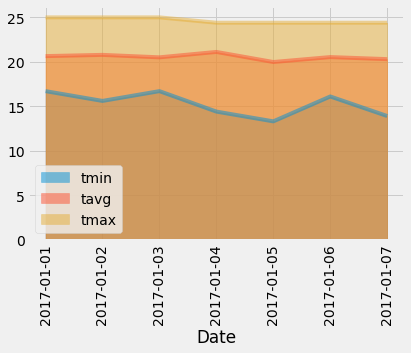

In [49]:
# Plot the daily normals as an area plot with `stacked=False`
thistory.plot.area(stacked=False)
plt.xticks(rotation=90)
plt.savefig("NORMAL DATA.png")

# Close session

In [50]:
# Close Session
session.close()